**Подключение библиотек**

In [236]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph
from shapely import geometry

ox.settings.bidirectional_network_types = ["drive"]

**Определение функций**

In [237]:
''' Определение тегов '''
tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

''' Построение датафрейма нужных фич '''
def func_tags(tags, city):
    try:
        gdf = ox.features_from_place(city, tags)
    except ox._errors.InsufficientResponseError:
        return None
    gdf = gdf[['name', 'geometry', 'nodes']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)
    ex = [gdf['n_osmid'].apply(lambda x: ox.geocode_to_gdf(x, by_osmid=True)[['lat', 'lon']]).iloc[:].values[x] for x in range(len(gdf))]
    dfs = pd.concat(ex, axis=0).reset_index(drop=True)
    gdf = gdf.merge(dfs, on=dfs.index)
    gdf = gdf.drop('key_0', axis=1)
    gdf = gdf[['name', 'lat', 'lon', 'geometry', 'nodes']]
    gdf['kind_of'] = list(tags.keys())[0]
    return gdf

''' Построение графа, получение датафрейма фич и получение датафрейма долгот и широт для дальшейших вычислений '''
def create_graph_city(name_city, my_network_type = None, my_filter = None):
    full_df = pd.concat([func_tags(tags_port, name_city), 
                                    func_tags(tags_aeroway, name_city), 
                                    func_tags(tags_landuse, name_city), 
                                    func_tags(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon


''' Формирование датафрейма фич '''
def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df


''' Создание датафрейма со всеми маршрутами '''
def create_graph_route(input_graph, f_df):
    one_route = []
    for i in range(f_df.shape[0]):
        for j in range(i + 1, f_df.shape[0]):
            try:
                one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))
            except nx.NetworkXNoPath:
                pass
            # one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))
    route_df = pd.DataFrame({'route' : one_route})
    return route_df


''' Создание из нескольких LineString один MultiLineString - нужно для финального графа '''
def create_gdf_graph(nn, ee):
    ii = 0
    list_line = []
    list_multi_line = []
    for i in range(nn.shape[0] - 1):
        idx = nn.iloc[i + 1].new_nodes
        for j in range(ii, ee.index.get_level_values('u').shape[0]):
            if ee.index.get_level_values('u')[j] != idx:
                for k in range(len(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values)):
                    list_line.append(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values[k])
            else : 
                ii = j
        multi_line = geometry.MultiLineString(list_line)
        list_line = []
        list_multi_line.append(multi_line)
    return list_multi_line


''' Построение финального графа путей '''
def create_final_graph(arb_graph, route_df, feature_df):
    list_graphs = []
    for i in range(route_df.route.shape[0]):
        r = route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])

    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(feature_df['new_nodes'].values)
    n = nodes[nodes['new_nodes'].isin(list_nodes)]

    list_multiline = create_gdf_graph(n, edges)
    edge_dict = {'u': n.new_nodes[:-1].values, 'v': n.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])
    edge_gdf['geometry'] = list_multiline
    graph_attrs = {"crs": "WGS84"}
    multi_digraph = ox.graph_from_gdfs(
        n, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph

In [238]:
def result(name_city):
    graph_city = create_graph_city(name_city, my_network_type = 'drive')
    feature_df = create_features_city(*graph_city)
    ox.distance.add_edge_lengths(graph_city[1], edges=None)
    route_df = create_graph_route(graph_city[1], feature_df)
    final_graph_1_drive = create_final_graph(graph_city[1], route_df, feature_df)
    return final_graph_1_drive

**Построение графа города Таллин**

C:\Users\orenc\AppData\Local\Temp\ipykernel_13956\3342642700.py:112: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


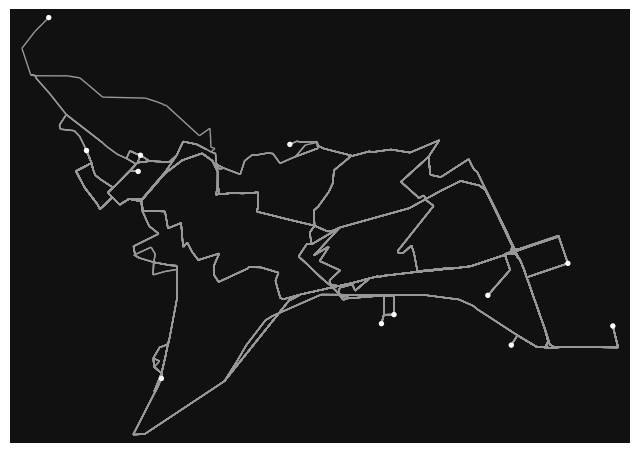

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [239]:
name_city = 'Tallin'
res_1 = result(name_city)
ox.plot_graph(res_1)

C:\Users\orenc\AppData\Local\Temp\ipykernel_13956\3342642700.py:112: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


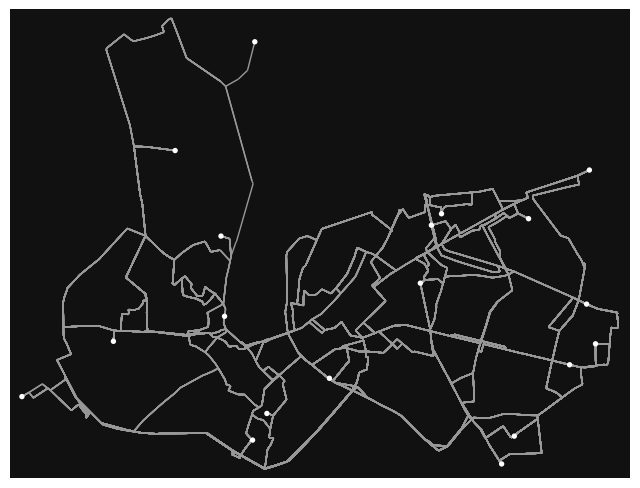

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [240]:
name_city = 'Riga'
res_2 = result(name_city)
ox.plot_graph(res_2)

**Датафрейм с координатами**

In [148]:
nodes_1, edges_1 = ox.graph_to_gdfs(res_1)

In [149]:
nodes_2, edges_2 = ox.graph_to_gdfs(res_2)

___

**Проверка**

C:\Users\orenc\AppData\Local\Temp\ipykernel_13956\1852991431.py:108: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


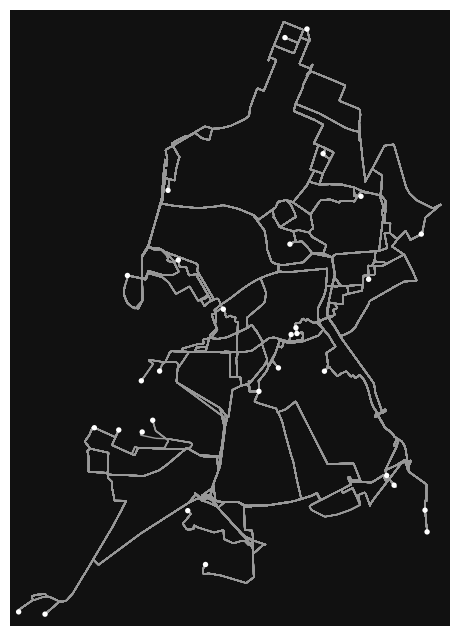

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [113]:
name_city = 'Saint Petersburg'
res_3 = result(name_city)
ox.plot_graph(res_3)

C:\Users\orenc\AppData\Local\Temp\ipykernel_13956\3342642700.py:112: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


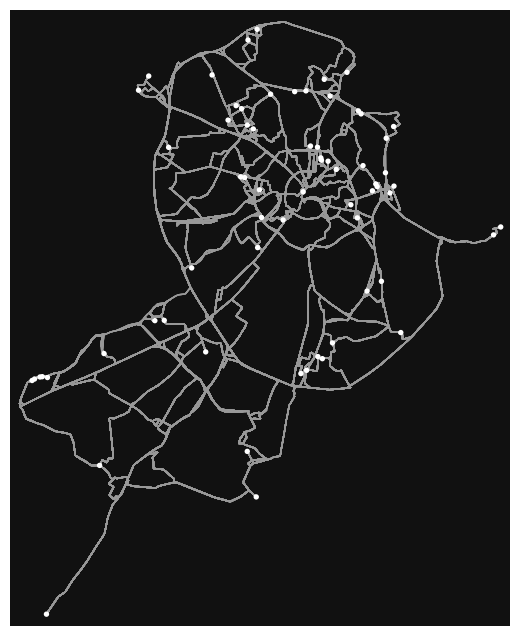

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [158]:
name_city = 'Moscow'
res_4 = result(name_city)
ox.plot_graph(res_4)

_______

In [352]:
tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

def func_tags_1(tags, city):
    list_lat_lon = []
    try:
        gdf = ox.features_from_place(city, tags).reset_index()
        gdf = gdf[['element_type', 'osmid']]
        gdf = gdf.dropna().reset_index()
        gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)
        for i in range(gdf.n_osmid.shape[0]):
            try:
                bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
                list_lat_lon.append(bb.iloc[:])
            except ox._errors.InsufficientResponseError:
                bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
                list_lat_lon.append(bb.iloc[:])
            dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
            gdf = gdf.merge(dfs, on=dfs.index)
            gdf = gdf.drop('key_0', axis=1)
            gdf = gdf[['lat', 'lon']]
            gdf['kind_of'] = list(tags.keys())[0]
    except ox._errors.InsufficientResponseError:
        return None

def create_graph_city_1(name_city, my_network_type = None, my_filter = None):
    full_df = pd.concat([func_tags_1(tags_port, name_city), 
                                    func_tags_1(tags_aeroway, name_city), 
                                    func_tags_1(tags_landuse, name_city), 
                                    func_tags_1(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon

def create_features_city_1(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df


def create_graph_route_1(input_graph, f_df):
    one_route = []
    for i in range(f_df.shape[0]):
        for j in range(i + 1, f_df.shape[0]):
            try:
                one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))
            except nx.NetworkXNoPath:
                pass
    route_df = pd.DataFrame({'route' : one_route})
    return route_df


def create_gdf_graph_1(nn, ee):
    ii = 0
    list_line = []
    list_multi_line = []
    for i in range(nn.shape[0] - 1):
        idx = nn.iloc[i + 1].new_nodes
        for j in range(ii, ee.index.get_level_values('u').shape[0]):
            if ee.index.get_level_values('u')[j] != idx:
                for k in range(len(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values)):
                    list_line.append(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values[k])
            else : 
                ii = j
        multi_line = geometry.MultiLineString(list_line)
        list_line = []
        list_multi_line.append(multi_line)
    return list_multi_line


def create_final_graph_1(arb_graph, route_df, feature_df):
    list_graphs = []
    for i in range(route_df.route.shape[0]):
        r = route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    if(len(list_graphs) > 0):
        my_graph = list_graphs[0]
        for i in range(1, len(list_graphs)):
            my_graph = nx.compose_all([my_graph, list_graphs[i]])

        nodes, edges = ox.graph_to_gdfs(my_graph)
        list_nodes = list(feature_df['new_nodes'].values)
        n = nodes[nodes['new_nodes'].isin(list_nodes)]

        list_multiline = create_gdf_graph_1(n, edges)
        edge_dict = {'u': n.new_nodes[:-1].values, 'v': n.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])
        edge_gdf['geometry'] = list_multiline
        graph_attrs = {"crs": "WGS84"}
        multi_digraph = ox.graph_from_gdfs(
            n, edge_gdf, graph_attrs=graph_attrs)
    else:
        return None
    
    return multi_digraph

In [349]:
# try:
#     gdf = ox.features_from_place('Tallin', tags_build).reset_index()
#     gdf = gdf[['element_type', 'osmid']]
#     gdf = gdf.dropna().reset_index()
#     gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)
#     try:
#         ex = [gdf['n_osmid'].apply(lambda x: ox.geocode_to_gdf(x, by_osmid=True)[['lat', 'lon']]).iloc[:].values[x] for x in range(len(gdf))]
#         dfs = pd.concat(ex, axis=0).reset_index(drop=True)
#         gdf = gdf.merge(dfs, on=dfs.index)
#         gdf = gdf.drop('key_0', axis=1)
#         gdf = gdf[['lat', 'lon']]
#         gdf['kind_of'] = list(tags_build.keys())[0]
#     except ox._errors.InsufficientResponseError:
#         pass
# except ox._errors.InsufficientResponseError:
#     pass

# gdf

In [348]:
# name_city = 'Tallin'
# gdf = ox.features_from_place(name_city, tags_build).reset_index()
# gdf = gdf[['element_type', 'osmid']]
# gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)

# list_lat_lon = []
# for i in range(gdf.n_osmid.shape[0]):
#     try:
#         bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
#         list_lat_lon.append(bb.iloc[:])
#     except ox._errors.InsufficientResponseError:
#         pass
#         # bb = None
#         # list_lat_lon.append(bb)
# dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
# gdf = gdf.merge(dfs, on=dfs.index).drop('key_0', axis=1)
# gdf = gdf[['lat', 'lon']]
# gdf['kind_of'] = list(tags_build.keys())[0]
# gdf

In [365]:
name_city = 'Tallin'

list_lat_lon = []
try:
    gdf = ox.features_from_place(name_city, tags_port).reset_index()
    gdf = gdf[['element_type', 'osmid']]
    gdf = gdf.dropna().reset_index()
    gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)
    for i in range(gdf.n_osmid.shape[0]):
        try:
            bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
            list_lat_lon.append(bb.iloc[:])
        except ox._errors.InsufficientResponseError:
            bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
            list_lat_lon.append(bb.iloc[:])
        dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
        # gdf = gdf.merge(dfs, on=dfs.index)
        # gdf = gdf.drop('key_0', axis=1)
        # gdf = gdf[['lat', 'lon']]
        # gdf['kind_of'] = list(tags_port.keys())[0]
except ox._errors.InsufficientResponseError:
    pass

# full_df = pd.concat([func_tags_1(tags_port, name_city), 
#                                     func_tags_1(tags_aeroway, name_city), 
#                                     func_tags_1(tags_landuse, name_city), 
#                                     func_tags_1(tags_build, name_city)], ignore_index=True)


# graph_city = create_graph_city_1(name_city, my_network_type = 'drive')
# feature_df = create_features_city_1(*graph_city)
# feature_df
# ox.distance.add_edge_lengths(graph_city[1], edges=None)
# route_df = create_graph_route_1(graph_city[1], feature_df)
# final_graph_1_drive = create_final_graph_1(graph_city[1], route_df, feature_df)
# final_graph_1_drive

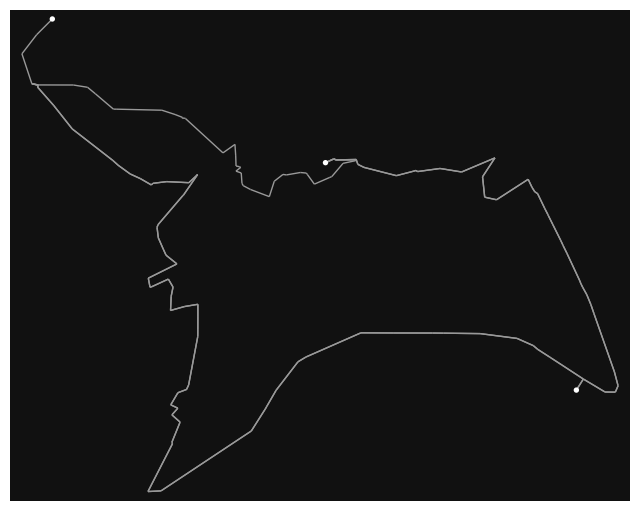

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [256]:
ox.plot_graph(final_graph_1_drive)

___

In [241]:
name_city = 'Vilnius'
res_5 = result(name_city)
ox.plot_graph(res_5)

KeyError: "['name'] not in index"

___

**Подсчет метрик**

In [134]:
metrics_1 = nx.degree_centrality(res_3)

In [135]:
metrics_2 = nx.closeness_centrality(res_3)

In [136]:
metrics_3 = nx.betweenness_centrality(res_3)

In [137]:
metrics_4 = nx.pagerank(res_3, alpha = 0.8)